In [1]:
%pip install pymongo


[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
%pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import pandas as pd
import numpy as np
from pymongo.mongo_client import MongoClient
from pymongo.server_api import ServerApi
from pymongo.errors import OperationFailure
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
import os
import io
import pickle

In [4]:
# Fazendo dataset para um sistema de ocorrências de bombeiros
N = 2000
df = pd.DataFrame({
    'ID': range(N),
    'Grupo de Ocorrência': np.random.choice(['Incêndio', 'Resgate', 'Acidente de Trânsito', 'Desabamento'], N),
    'Tipo de Ocorrência': np.random.choice(['Residencial', 'Comercial', 'Industrial', 'Público'], N),
    'Prioridade': np.random.choice(['Baixa', 'Média', 'Alta', 'Crítica'], N),
    'Tempo de Resposta (minutos)': np.random.randint(5, 60, N),
    'Número de Vítimas': np.random.randint(0, 10, N),
    'Danos Estimados (R$)': np.random.randint(1000, 50000, N)
})
df

,ID,Grupo de Ocorrência,Tipo de Ocorrência,Prioridade,Tempo de Resposta (minutos),Número de Vítimas,Danos Estimados (R$)
0,0,Resgate,Residencial,Média,33,1,24135
1,1,Acidente de Trânsito,Industrial,Baixa,15,1,48756
2,2,Acidente de Trânsito,Comercial,Média,56,5,18040
3,3,Acidente de Trânsito,Público,Alta,28,5,4970
4,4,Desabamento,Industrial,Alta,42,9,33423
...,...,...,...,...,...,...,...
1995,1995,Incêndio,Comercial,Alta,37,2,1959
1996,1996,Incêndio,Industrial,Baixa,51,9,32599
1997,1997,Incêndio,Público,Crítica,59,3,35764
1998,1998,Incêndio,Comercial,Baixa,15,6,17057


In [5]:
#df to json
df.to_json('df.json', orient='records', lines=True)

In [7]:
# MongoDB Connection
MONGO_URI = os.environ.get('MONGO_URI', 'mongodb://localhost:27017/')
client = MongoClient(MONGO_URI)
db = client["bombeiros"]
collection = db["bombeiros"]

# Send a ping to confirm a successful connection
try:
    client.admin.command('ping')
    print("Conectado ao MongoDB!")
except Exception as e:
    print('MongoDB ping failed:', type(e).__name__, e)
    print('If youre using Atlas, ensure your connection string includes credentials and your IP is whitelisted.')
    raise

with open('df.json', 'r', encoding='utf-8') as file:
    for line in file:
        line = line.strip()
        if not line:
            continue
        # Use io.StringIO(line) to pass a file-like object instead of a literal string
        record = pd.read_json(io.StringIO(line), typ='series') 
        # convert numpy scalars to native Python types to avoid BSON type issues
        doc = record.apply(lambda x: x.item() if hasattr(x, "item") else x).to_dict()
        try:
            collection.insert_one(doc)
        except OperationFailure as e:
            print('Inserção falhou com OperationFailure:', e)
            print('Check credentials/permissions, and ensure the user has insert privileges. If using Atlas, verify the connection string and IP access list.')
            raise

print("Inserção de dados completa!")

Conectado ao MongoDB!
Inserção de dados completa!


In [8]:
target_variable = "Tempo de Resposta (minutos)"  

# 1. Tratamento de valores nulos
df.fillna(df.median(numeric_only=True), inplace=True)
df.fillna("None", inplace=True)

# 2. Codificação das variáveis categóricas
cat_cols = df.select_dtypes(include=["object"]).columns
encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    encoders[col] = le

print(f"\nVariáveis categóricas codificadas: {list(cat_cols)}")

# 3. Separar variáveis preditoras e alvo
X = df.drop(columns=[target_variable, "ID"])
y = df[target_variable]

print(f"\nVariáveis preditoras: {X.columns.tolist()}")
print(f"Variável alvo: {target_variable}")

# 4. Separação treino/teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"\nDimensões dos conjuntos:")
print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}, y_test: {y_test.shape}")


Variáveis categóricas codificadas: ['Grupo de Ocorrência', 'Tipo de Ocorrência', 'Prioridade']

Variáveis preditoras: ['Grupo de Ocorrência', 'Tipo de Ocorrência', 'Prioridade', 'Número de Vítimas', 'Danos Estimados (R$)']
Variável alvo: Tempo de Resposta (minutos)

Dimensões dos conjuntos:
X_train: (1600, 5), X_test: (400, 5)
y_train: (1600,), y_test: (400,)


In [9]:
# Treinamento do Modelo

# Treinar modelo RandomForest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Fazer previsões
y_pred = rf.predict(X_test)

# Avaliar o modelo
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\n--- Avaliação do Modelo ---")
print(f"MAE (Mean Absolute Error): {mae:.2f}")
print(f"MSE (Mean Squared Error): {mse:.2f}")
print(f"R² Score: {r2:.2f}")


--- Avaliação do Modelo ---
MAE (Mean Absolute Error): 13.93
MSE (Mean Squared Error): 277.37
R² Score: -0.14


In [10]:
# Analisar importância das features
importances = rf.feature_importances_
feature_names = X_train.columns
indices = np.argsort(importances)[::-1]

print("\n--- Importância das Variáveis ---")
for i in range(len(indices)):
    print(f"{i+1}. {feature_names[indices[i]]}: {importances[indices[i]]:.4f}")


--- Importância das Variáveis ---
1. Danos Estimados (R$): 0.5394
2. Número de Vítimas: 0.1764
3. Prioridade: 0.0958
4. Tipo de Ocorrência: 0.0951
5. Grupo de Ocorrência: 0.0932


In [11]:
def predict_occurrence():
    
    print("\n" + "="*50)
    print("SISTEMA DE PREDIÇÃO DE OCORRÊNCIAS DOS BOMBEIROS")
    print("="*50)
    
    # Mostrar variáveis importantes
    print("\nTop 3 variáveis mais importantes para a predição:")
    for i in range(min(3, len(indices))):
        print(f"  {i+1}. {feature_names[indices[i]]}")
    
    print(f"\nVariável sendo prevista: {target_variable}")
    print("\nPor favor, informe os dados da ocorrência:")
    
    # Coletar inputs do usuário
    user_input = {}
    
    for feature in X.columns:
        if feature in encoders:
            # Variável categórica - mostrar opções disponíveis
            le = encoders[feature]
            original_values = le.classes_
            print(f"\n{feature} - Opções disponíveis: {list(original_values)}")
            user_value = input(f"Digite o valor para '{feature}': ")
            
            try:
                encoded_value = le.transform([user_value])[0]
                user_input[feature] = encoded_value
            except ValueError:
                print(f"Valor inválido! Usando valor padrão: {original_values[0]}")
                user_input[feature] = le.transform([original_values[0]])[0]
        else:
            # Variável numérica
            user_value = input(f"Digite o valor para '{feature}' (numérico): ")
            try:
                user_input[feature] = float(user_value)
            except ValueError:
                print(f"Valor inválido! Usando valor médio: {X[feature].mean():.2f}")
                user_input[feature] = X[feature].mean()
    
    # Criar DataFrame para predição
    input_df = pd.DataFrame([user_input], columns=X.columns)
    
    # Fazer predição
    prediction = rf.predict(input_df)[0]
    
    print("\n" + "="*50)
    print("RESULTADO DA PREDIÇÃO")
    print("="*50)
    print(f"{target_variable} previsto(a): {prediction:.2f}")
    
    # Mostrar interpretação baseada na variável alvo
    if target_variable == "Tempo de Resposta (minutos)":
        if prediction <= 15:
            print("Classificação: Resposta RÁPIDA")
        elif prediction <= 30:
            print("Classificação: Resposta MÉDIA")
        else:
            print("Classificação: Resposta LENTA")
    elif target_variable == "Número de Vítimas":
        if prediction == 0:
            print("Classificação: Sem vítimas")
        elif prediction <= 3:
            print("Classificação: Poucas vítimas")
        else:
            print("Classificação: Múltiplas vítimas")
    elif target_variable == "Danos Estimados (R$)":
        if prediction <= 10000:
            print("Classificação: Danos LEVES")
        elif prediction <= 25000:
            print("Classificação: Danos MODERADOS")
        else:
            print("Classificação: Danos GRAVES")

# Executar predição interativa
predict_occurrence()


SISTEMA DE PREDIÇÃO DE OCORRÊNCIAS DOS BOMBEIROS

Top 3 variáveis mais importantes para a predição:
  1. Danos Estimados (R$)
  2. Número de Vítimas
  3. Prioridade

Variável sendo prevista: Tempo de Resposta (minutos)

Por favor, informe os dados da ocorrência:

Grupo de Ocorrência - Opções disponíveis: ['Acidente de Trânsito', 'Desabamento', 'Incêndio', 'Resgate']

Tipo de Ocorrência - Opções disponíveis: ['Comercial', 'Industrial', 'Público', 'Residencial']

Prioridade - Opções disponíveis: ['Alta', 'Baixa', 'Crítica', 'Média']

RESULTADO DA PREDIÇÃO
Tempo de Resposta (minutos) previsto(a): 28.26
Classificação: Resposta MÉDIA


In [12]:
# Salvar modelo
model_filename = 'bombeiros_model.pkl'
with open(model_filename, 'wb') as f:
    pickle.dump(rf, f)

# Salvar encoders
encoders_filename = 'encoders.pkl'
with open(encoders_filename, 'wb') as f:
    pickle.dump(encoders, f)

print(f"\nModelo salvo em: {model_filename}")
print(f"Encoders salvos em: {encoders_filename}")


Modelo salvo em: bombeiros_model.pkl
Encoders salvos em: encoders.pkl


In [13]:
# Predição rápida com valores de exemplo
def quick_prediction(grupo_ocorrencia, tipo_ocorrencia, prioridade, num_vitimas):
    
    # Codificar valores categóricos
    grupo_encoded = encoders['Grupo de Ocorrência'].transform([grupo_ocorrencia])[0]
    tipo_encoded = encoders['Tipo de Ocorrência'].transform([tipo_ocorrencia])[0]
    prioridade_encoded = encoders['Prioridade'].transform([prioridade])[0]
    
    # Criar input
    input_data = {
        'Grupo de Ocorrência': grupo_encoded,
        'Tipo de Ocorrência': tipo_encoded,
        'Prioridade': prioridade_encoded,
        'Número de Vítimas': num_vitimas,
        'Danos Estimados (R$)': 15000  # Valor médio
    }
    
    input_df = pd.DataFrame([input_data], columns=X.columns)
    prediction = rf.predict(input_df)[0]
    
    print(f"\nPredição para {grupo_ocorrencia} - {tipo_ocorrencia}:")
    print(f"{target_variable}: {prediction:.2f}")

# Exemplos de uso
quick_prediction('Incêndio', 'Residencial', 'Alta', 2)
quick_prediction('Acidente de Trânsito', 'Público', 'Crítica', 5)


Predição para Incêndio - Residencial:
Tempo de Resposta (minutos): 30.86

Predição para Acidente de Trânsito - Público:
Tempo de Resposta (minutos): 29.88


In [14]:
%pip install matplotlib seaborn


[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


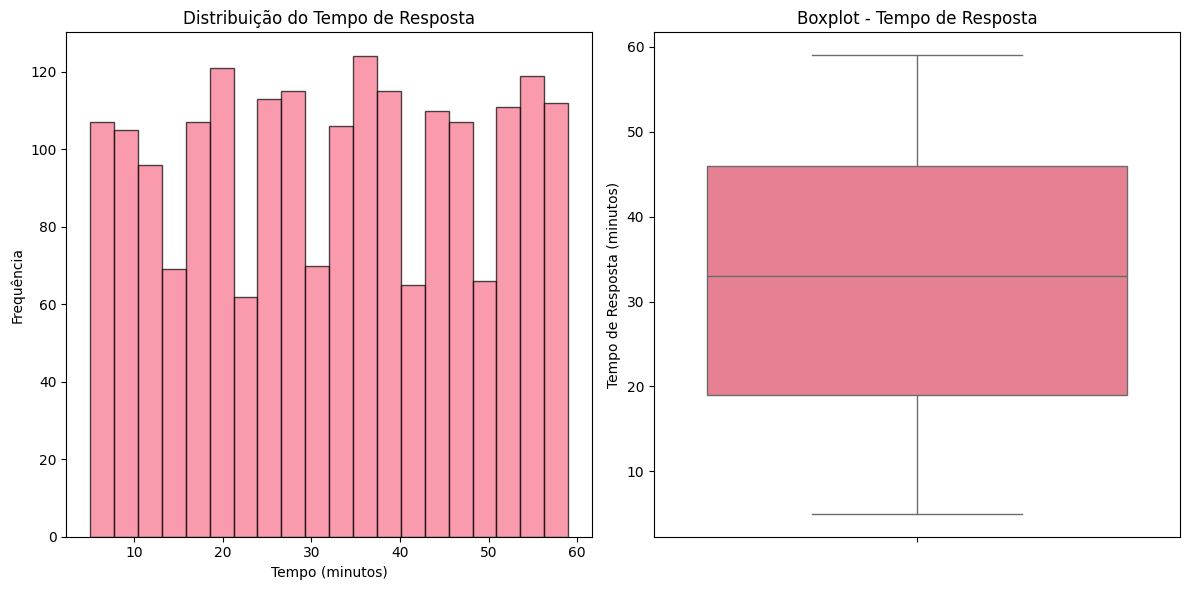

In [15]:
#Gráficos de Distribuição e Frequência
import matplotlib.pyplot as plt
import seaborn as sns

# Configuração do estilo
plt.style.use('default')
sns.set_palette("husl")

# 1. Distribuição do Tempo de Resposta
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(df['Tempo de Resposta (minutos)'], bins=20, alpha=0.7, edgecolor='black')
plt.title('Distribuição do Tempo de Resposta')
plt.xlabel('Tempo (minutos)')
plt.ylabel('Frequência')

plt.subplot(1, 2, 2)
sns.boxplot(y=df['Tempo de Resposta (minutos)'])
plt.title('Boxplot - Tempo de Resposta')
plt.tight_layout()
plt.show()

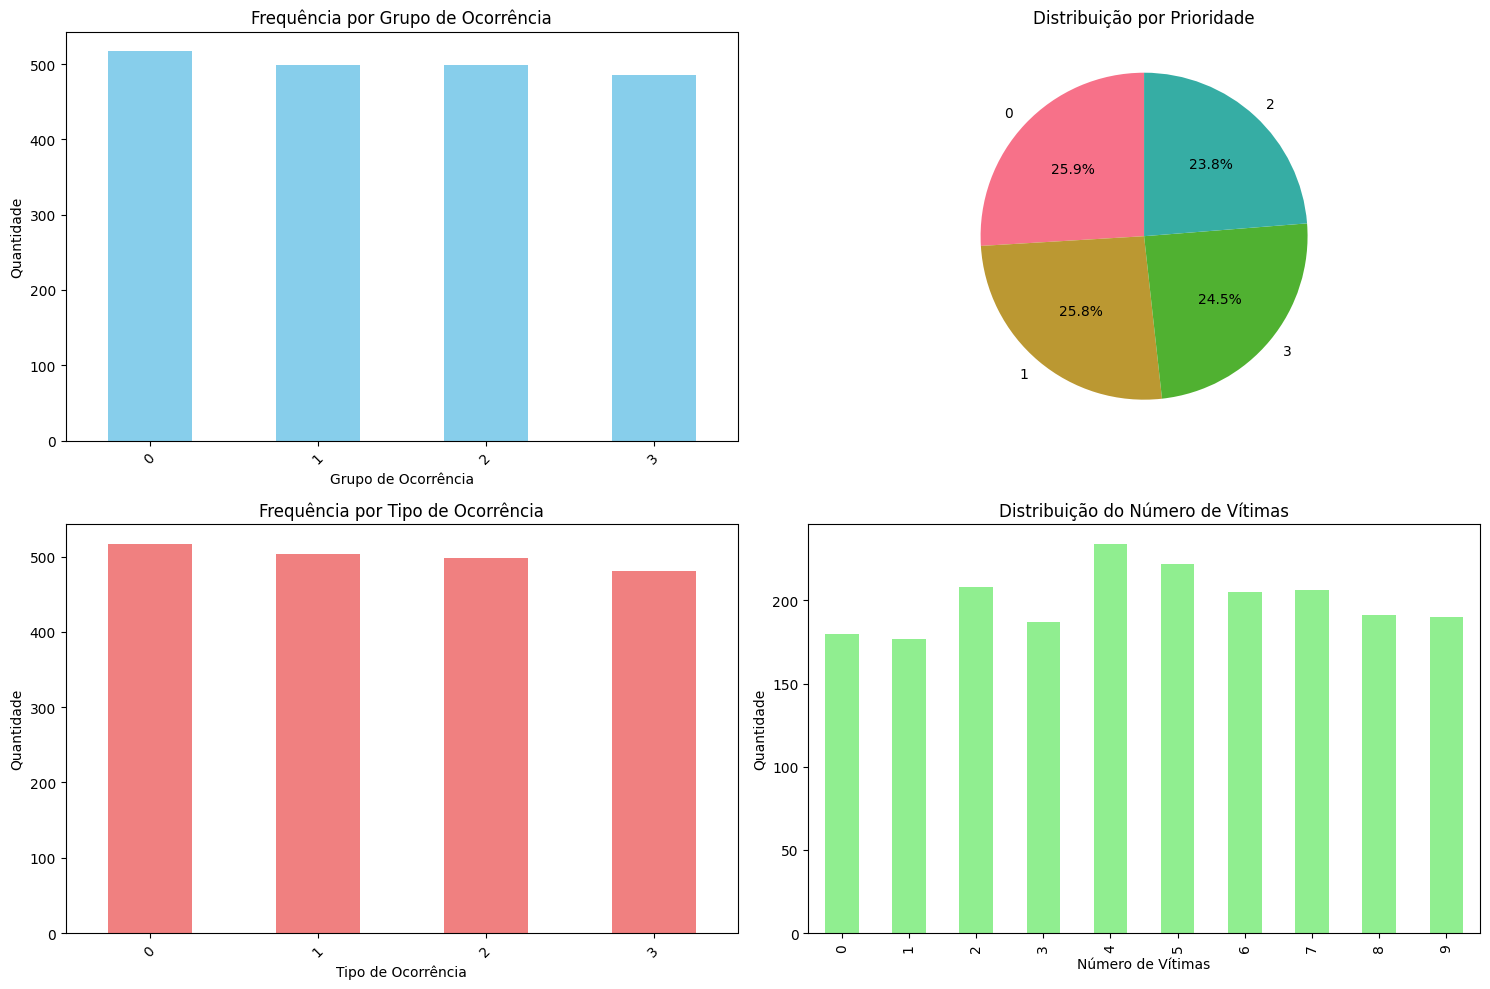

In [16]:
# 2. Frequência dos Tipos de Ocorrência
plt.figure(figsize=(15, 10))

# Gráfico de barras para Grupo de Ocorrência
plt.subplot(2, 2, 1)
df['Grupo de Ocorrência'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Frequência por Grupo de Ocorrência')
plt.xticks(rotation=45)
plt.ylabel('Quantidade')

# Gráfico de pizza para Prioridade
plt.subplot(2, 2, 2)
df['Prioridade'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.title('Distribuição por Prioridade')
plt.ylabel('')

# Gráfico de barras para Tipo de Ocorrência
plt.subplot(2, 2, 3)
df['Tipo de Ocorrência'].value_counts().plot(kind='bar', color='lightcoral')
plt.title('Frequência por Tipo de Ocorrência')
plt.xticks(rotation=45)
plt.ylabel('Quantidade')

# Distribuição do Número de Vítimas
plt.subplot(2, 2, 4)
df['Número de Vítimas'].value_counts().sort_index().plot(kind='bar', color='lightgreen')
plt.title('Distribuição do Número de Vítimas')
plt.xlabel('Número de Vítimas')
plt.ylabel('Quantidade')

plt.tight_layout()
plt.show()

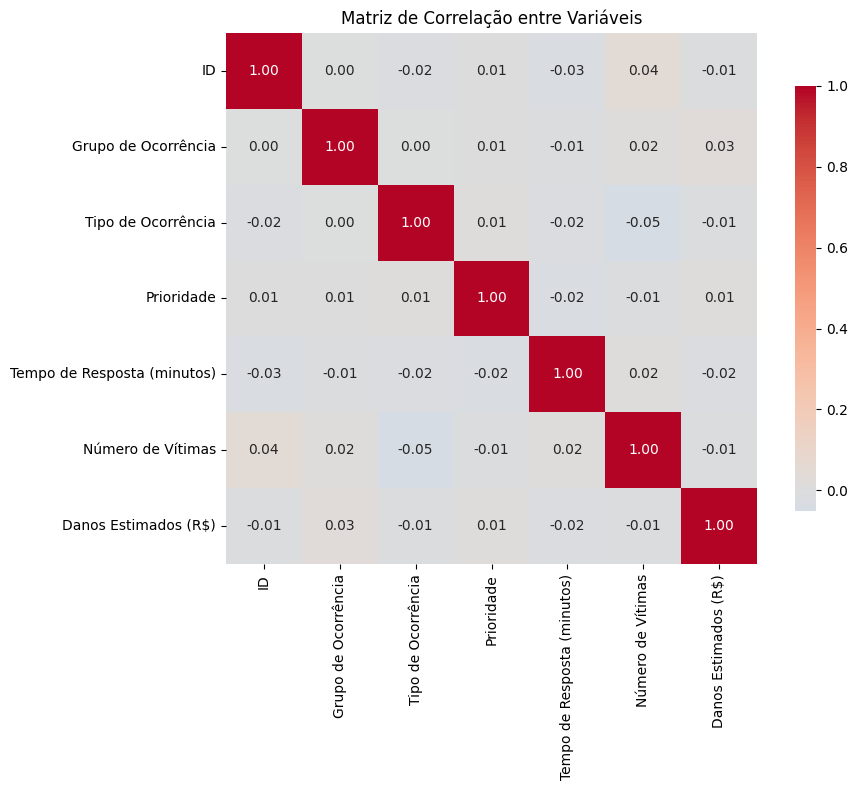

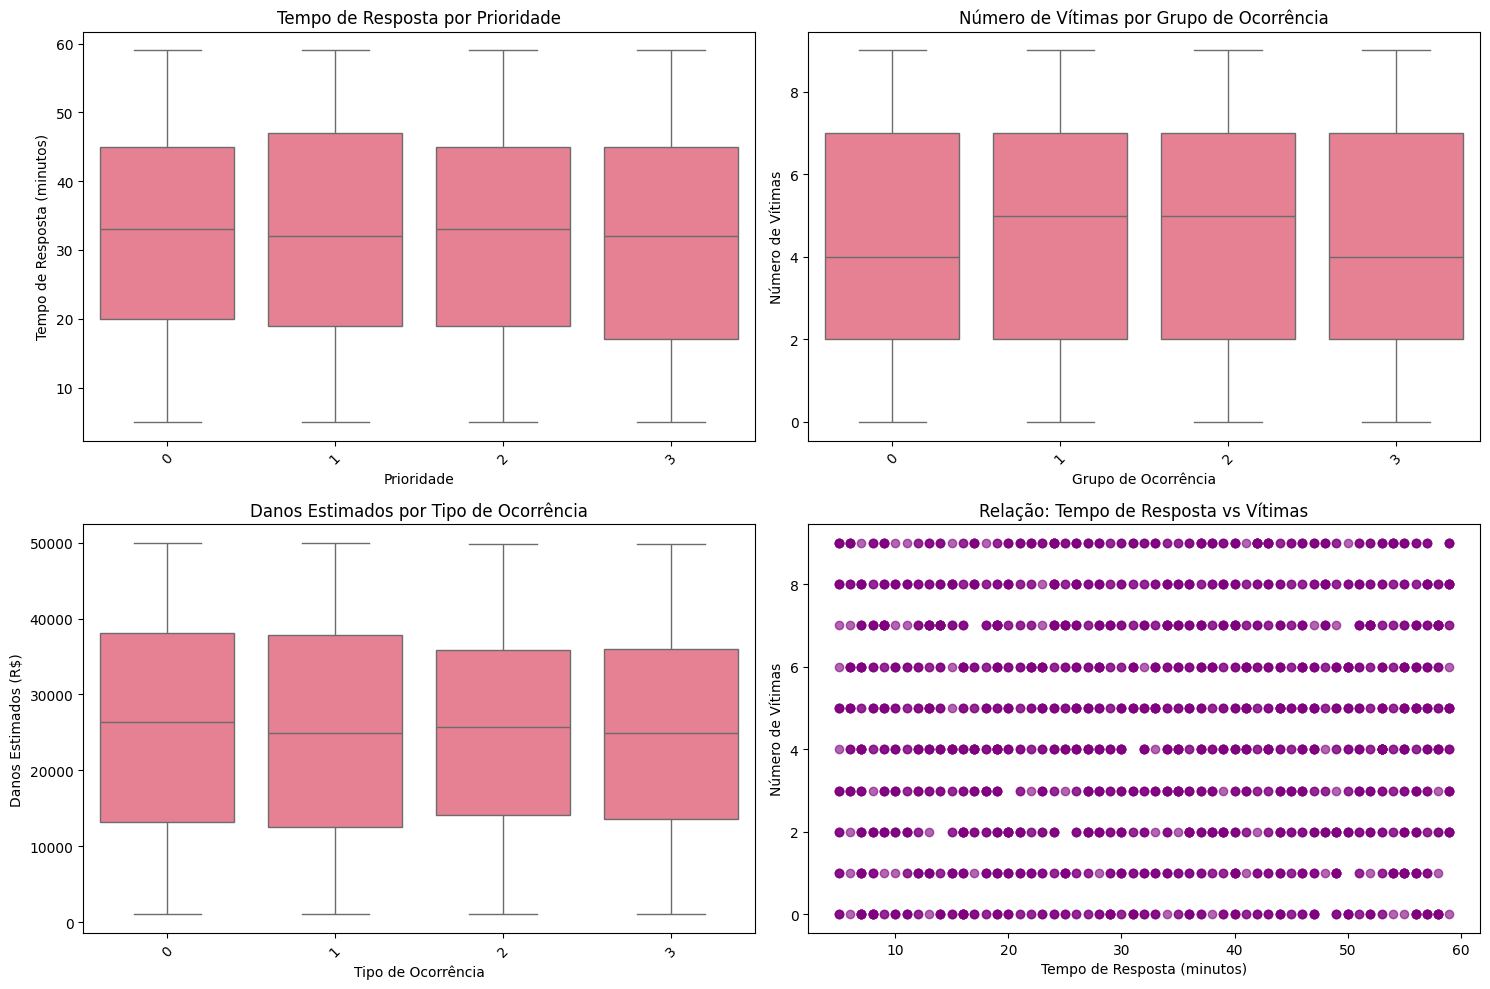

In [17]:
# Gráficos de relação e correlação

# 3. Matriz de Correlação
plt.figure(figsize=(10, 8))

# Converter variáveis categóricas para numéricas para correlação
df_numeric = df.copy()
for col in ['Grupo de Ocorrência', 'Tipo de Ocorrência', 'Prioridade']:
    df_numeric[col] = LabelEncoder().fit_transform(df_numeric[col])

correlation_matrix = df_numeric.corr()

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, fmt='.2f', cbar_kws={'shrink': 0.8})
plt.title('Matriz de Correlação entre Variáveis')
plt.tight_layout()
plt.show()

# 4. Relação entre Variáveis
plt.figure(figsize=(15, 10))

# Tempo de Resposta vs Prioridade
plt.subplot(2, 2, 1)
sns.boxplot(data=df, x='Prioridade', y='Tempo de Resposta (minutos)')
plt.title('Tempo de Resposta por Prioridade')
plt.xticks(rotation=45)

# Número de Vítimas vs Grupo de Ocorrência
plt.subplot(2, 2, 2)
sns.boxplot(data=df, x='Grupo de Ocorrência', y='Número de Vítimas')
plt.title('Número de Vítimas por Grupo de Ocorrência')
plt.xticks(rotation=45)

# Danos vs Tipo de Ocorrência
plt.subplot(2, 2, 3)
sns.boxplot(data=df, x='Tipo de Ocorrência', y='Danos Estimados (R$)')
plt.title('Danos Estimados por Tipo de Ocorrência')
plt.xticks(rotation=45)

# Scatter Plot: Tempo de Resposta vs Número de Vítimas
plt.subplot(2, 2, 4)
plt.scatter(df['Tempo de Resposta (minutos)'], df['Número de Vítimas'], 
           alpha=0.6, color='purple')
plt.xlabel('Tempo de Resposta (minutos)')
plt.ylabel('Número de Vítimas')
plt.title('Relação: Tempo de Resposta vs Vítimas')

plt.tight_layout()
plt.show()

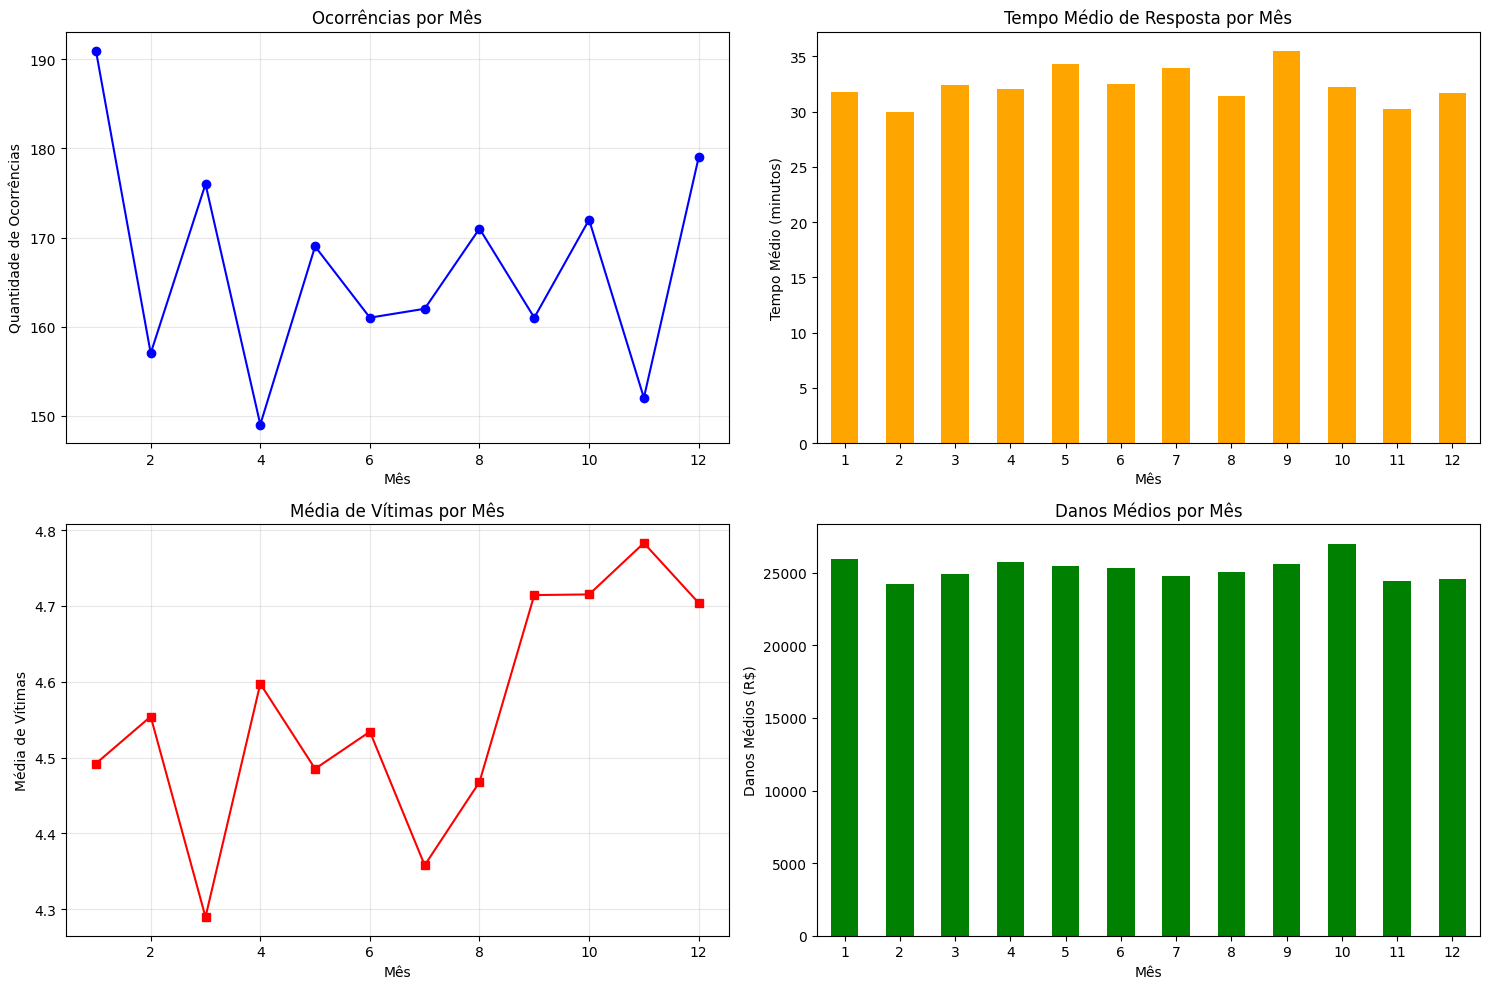

In [18]:
#Gráficos de análise temporal

# 5. Análise Temporal (se seus dados tiverem timestamp)
# Criando uma coluna de mês fictícia para exemplo
np.random.seed(42)
df['Mês'] = np.random.randint(1, 13, len(df))

plt.figure(figsize=(15, 10))

# Ocorrências por mês
plt.subplot(2, 2, 1)
df['Mês'].value_counts().sort_index().plot(kind='line', marker='o', color='blue')
plt.title('Ocorrências por Mês')
plt.xlabel('Mês')
plt.ylabel('Quantidade de Ocorrências')
plt.grid(True, alpha=0.3)

# Tempo médio de resposta por mês
plt.subplot(2, 2, 2)
df.groupby('Mês')['Tempo de Resposta (minutos)'].mean().plot(kind='bar', color='orange')
plt.title('Tempo Médio de Resposta por Mês')
plt.xlabel('Mês')
plt.ylabel('Tempo Médio (minutos)')
plt.xticks(rotation=0)

# Vítimas médias por mês
plt.subplot(2, 2, 3)
df.groupby('Mês')['Número de Vítimas'].mean().plot(kind='line', marker='s', color='red')
plt.title('Média de Vítimas por Mês')
plt.xlabel('Mês')
plt.ylabel('Média de Vítimas')
plt.grid(True, alpha=0.3)

# Danos médios por mês
plt.subplot(2, 2, 4)
df.groupby('Mês')['Danos Estimados (R$)'].mean().plot(kind='bar', color='green')
plt.title('Danos Médios por Mês')
plt.xlabel('Mês')
plt.ylabel('Danos Médios (R$)')
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

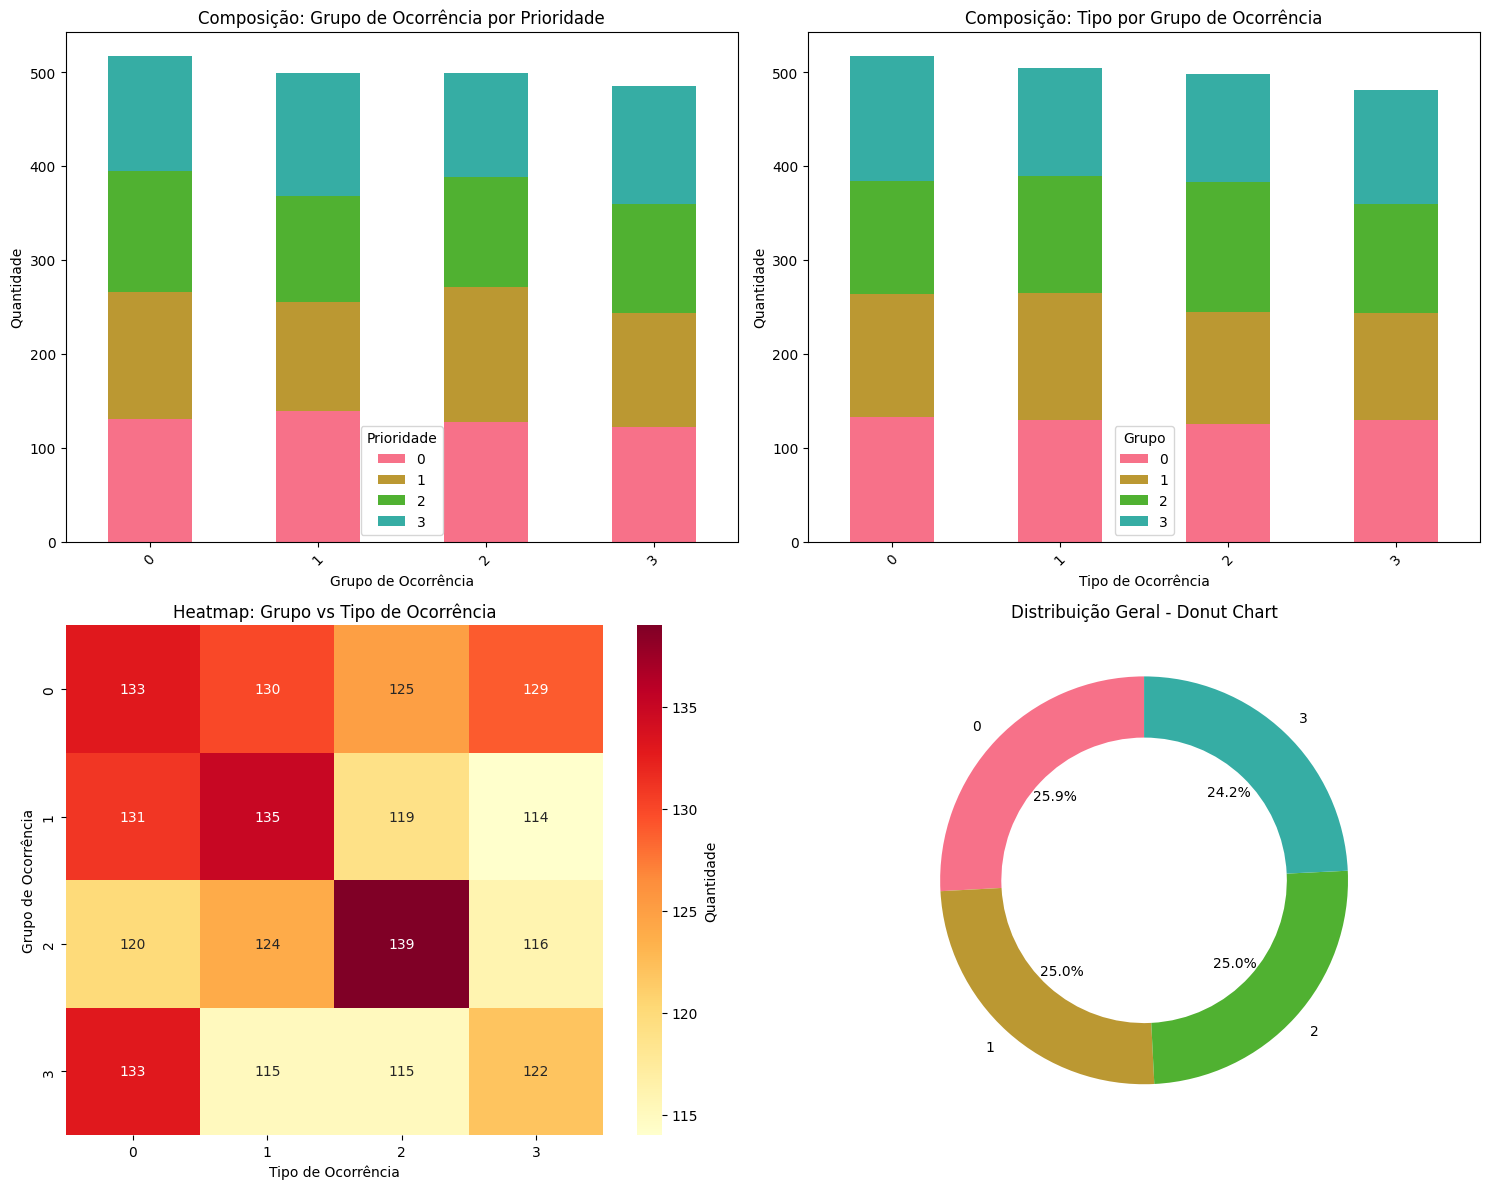

In [19]:
#Gráficos de Composição e Stack

# 6. Composição das Ocorrências
plt.figure(figsize=(15, 12))

# Stacked bar: Grupo de Ocorrência por Prioridade
plt.subplot(2, 2, 1)
cross_tab = pd.crosstab(df['Grupo de Ocorrência'], df['Prioridade'])
cross_tab.plot(kind='bar', stacked=True, ax=plt.gca())
plt.title('Composição: Grupo de Ocorrência por Prioridade')
plt.xticks(rotation=45)
plt.ylabel('Quantidade')
plt.legend(title='Prioridade')

# Stacked bar: Tipo de Ocorrência por Grupo
plt.subplot(2, 2, 2)
cross_tab2 = pd.crosstab(df['Tipo de Ocorrência'], df['Grupo de Ocorrência'])
cross_tab2.plot(kind='bar', stacked=True, ax=plt.gca())
plt.title('Composição: Tipo por Grupo de Ocorrência')
plt.xticks(rotation=45)
plt.ylabel('Quantidade')
plt.legend(title='Grupo')

# Heatmap de Frequência Cruzada
plt.subplot(2, 2, 3)
cross_tab3 = pd.crosstab(df['Grupo de Ocorrência'], df['Tipo de Ocorrência'])
sns.heatmap(cross_tab3, annot=True, fmt='d', cmap='YlOrRd', cbar_kws={'label': 'Quantidade'})
plt.title('Heatmap: Grupo vs Tipo de Ocorrência')
plt.ylabel('Grupo de Ocorrência')
plt.xlabel('Tipo de Ocorrência')

# Donut chart - Distribuição Geral
plt.subplot(2, 2, 4)
size = df['Grupo de Ocorrência'].value_counts()
plt.pie(size, labels=size.index, autopct='%1.1f%%', startangle=90,
        wedgeprops=dict(width=0.3))
plt.title('Distribuição Geral - Donut Chart')
plt.gca().add_artist(plt.Circle((0,0),0.2,fc='white'))

plt.tight_layout()
plt.show()

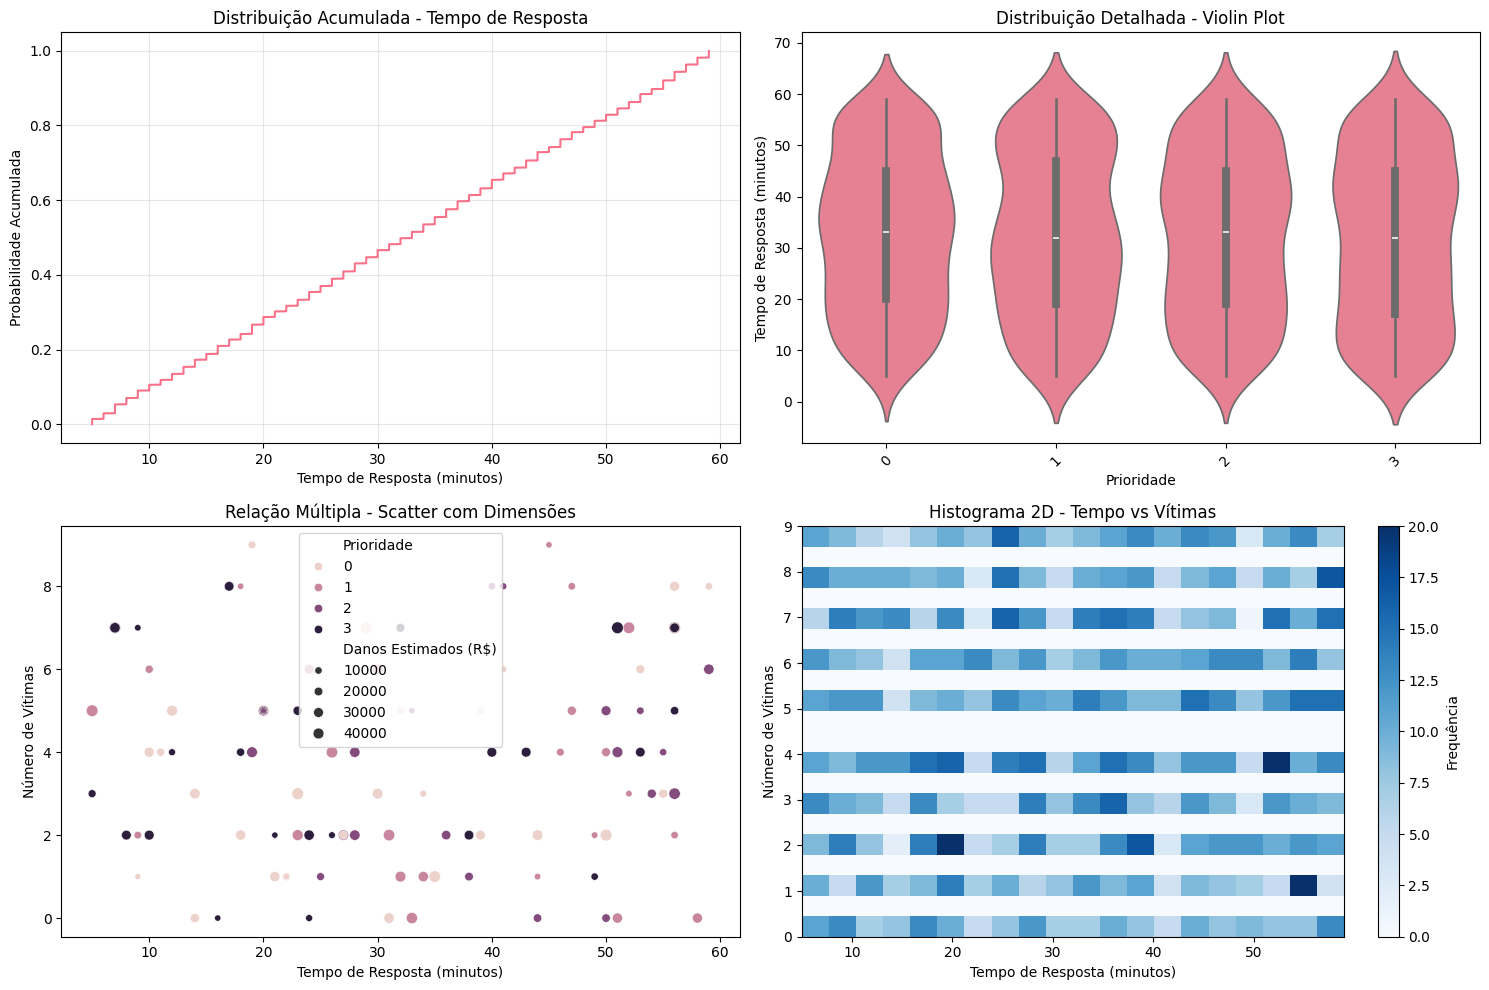

In [20]:
#Gráficos Estatísticos Avançados

# 7. Análises Estatísticas Avançadas
plt.figure(figsize=(15, 10))

# Distribuição cumulativa do tempo de resposta
plt.subplot(2, 2, 1)
df_sorted = df['Tempo de Resposta (minutos)'].sort_values()
plt.plot(df_sorted, np.arange(len(df_sorted)) / len(df_sorted))
plt.title('Distribuição Acumulada - Tempo de Resposta')
plt.xlabel('Tempo de Resposta (minutos)')
plt.ylabel('Probabilidade Acumulada')
plt.grid(True, alpha=0.3)

# Violin plot - Tempo de resposta por prioridade
plt.subplot(2, 2, 2)
sns.violinplot(data=df, x='Prioridade', y='Tempo de Resposta (minutos)')
plt.title('Distribuição Detalhada - Violin Plot')
plt.xticks(rotation=45)

# Pairplot (amostra menor para melhor visualização)
plt.subplot(2, 2, 3)
sample_df = df_numeric.sample(100)  # Amostra para não sobrecarregar
sns.scatterplot(data=sample_df, x='Tempo de Resposta (minutos)', 
                y='Número de Vítimas', hue='Prioridade', size='Danos Estimados (R$)')
plt.title('Relação Múltipla - Scatter com Dimensões')

# Histograma 2D
plt.subplot(2, 2, 4)
plt.hist2d(df['Tempo de Resposta (minutos)'], df['Número de Vítimas'], 
           bins=20, cmap='Blues')
plt.colorbar(label='Frequência')
plt.xlabel('Tempo de Resposta (minutos)')
plt.ylabel('Número de Vítimas')
plt.title('Histograma 2D - Tempo vs Vítimas')

plt.tight_layout()
plt.show()

PAINEL ESTATÍSTICO - OCORRÊNCIAS DOS BOMBEIROS

ESTATÍSTICAS GERAIS:
Total de Ocorrências: 2,000
Tempo Médio de Resposta: 32.3 minutos
Total de Vítimas: 9,110
Danos Totais Estimados: R$ 50,559,161

OCORRÊNCIAS MAIS COMUNS:
Grupo mais frequente: 0
Tipo mais frequente: 0
Prioridade mais comum: 0

ESTATÍSTICAS DE GRAVIDADE:
Média de vítimas por ocorrência: 4.55
Ocorrência com mais vítimas: 9
Danos médios por ocorrência: R$ 25,279.58


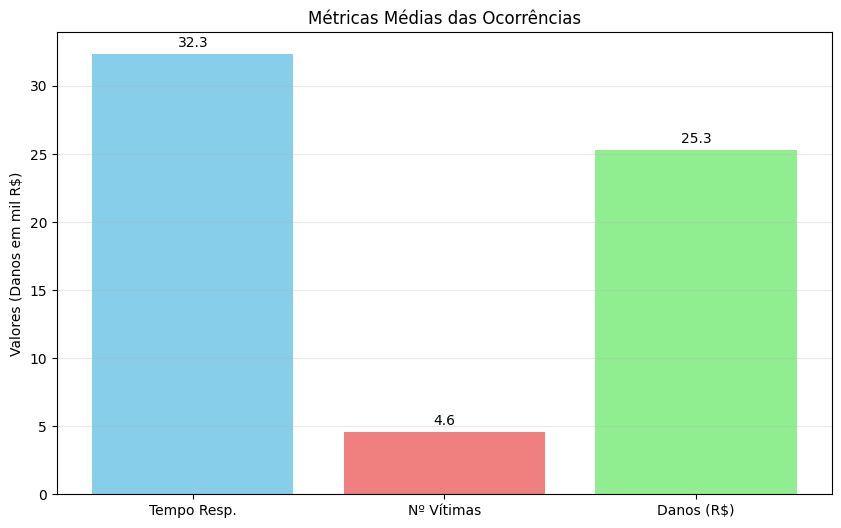

In [21]:
# 8. Painel de Métricas Resumidas
print("="*50)
print("PAINEL ESTATÍSTICO - OCORRÊNCIAS DOS BOMBEIROS")
print("="*50)

print(f"\nESTATÍSTICAS GERAIS:")
print(f"Total de Ocorrências: {len(df):,}")
print(f"Tempo Médio de Resposta: {df['Tempo de Resposta (minutos)'].mean():.1f} minutos")
print(f"Total de Vítimas: {df['Número de Vítimas'].sum():,}")
print(f"Danos Totais Estimados: R$ {df['Danos Estimados (R$)'].sum():,}")

print(f"\nOCORRÊNCIAS MAIS COMUNS:")
print(f"Grupo mais frequente: {df['Grupo de Ocorrência'].mode()[0]}")
print(f"Tipo mais frequente: {df['Tipo de Ocorrência'].mode()[0]}")
print(f"Prioridade mais comum: {df['Prioridade'].mode()[0]}")

print(f"\nESTATÍSTICAS DE GRAVIDADE:")
print(f"Média de vítimas por ocorrência: {df['Número de Vítimas'].mean():.2f}")
print(f"Ocorrência com mais vítimas: {df['Número de Vítimas'].max()}")
print(f"Danos médios por ocorrência: R$ {df['Danos Estimados (R$)'].mean():,.2f}")

# Gráfico resumo final
plt.figure(figsize=(10, 6))
metrics = ['Tempo Resp.', 'Nº Vítimas', 'Danos (R$)']
values = [
    df['Tempo de Resposta (minutos)'].mean(),
    df['Número de Vítimas'].mean(),
    df['Danos Estimados (R$)'].mean() / 1000  # Em milhares
]

plt.bar(metrics, values, color=['skyblue', 'lightcoral', 'lightgreen'])
plt.title('Métricas Médias das Ocorrências')
plt.ylabel('Valores (Danos em mil R$)')
for i, v in enumerate(values):
    plt.text(i, v + max(values)*0.01, f'{v:.1f}', ha='center', va='bottom')
plt.grid(True, alpha=0.3, axis='y')
plt.show()